<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/Monocle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
This is the Google colab version of the Monocle 2 notebook on the [kallisto | bustools R notebook website](https://bustools.github.io/BUS_notebooks_R/monocle2.html). This version follows the static version closely, but uses the [10xv3 1k E18 mouse neuron dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_1k_v3) to reduce download time and runtime for interactive use here. Google colab gives each notebook a fresh Ubuntu machine with R and some common packages pre-installed. Here we install the packages used in the downstream analysis that are not pre-installed. This takes a while, as some of the packages have several dependencies that have C++ code; it seems that most of time spent installing these packages is spent on compiling C++ code. Package installation might not have taken this long in your experience, since you most likely already have many of the common dependencies installed on your computer, which is not the case here.

In [0]:
install.packages("BiocManager")
BiocManager::install(c("DropletUtils", "monocle", "SingleR", "BUSpaRse", "scater", "scran"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'DropletUtils', 'monocle', 'SingleR',
  'BUSpaRse'

also installing the dependencies ‘formatR’, ‘bit’, ‘vctrs’, ‘lambda.r’, ‘futile.options’, ‘bitops’, ‘interactiveDisplayBase’, ‘bit64’, ‘blob’, ‘DBI’, ‘zlibbioc’, ‘Rhtslib’, ‘futile.logger’, ‘snow’, ‘locfit’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘RcppEigen’, ‘FNN’, ‘ggrepel’, ‘gridExtra’, ‘sparsesvd’, ‘docopt’, ‘graph’, ‘RBGL’, ‘XML’, ‘RCurl’, ‘RUnit’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘AnnotationHub’, ‘BiocFileCache’, ‘rappdirs’, ‘RSQLite’, ‘XVector’, ‘rtracklayer’, ‘Rsamtools’, ‘ProtGenerics’, ‘GenomeInfoDbData’, ‘GenomicAlignments’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘Rhdf5lib’, ‘Biobase’, ‘VGAM’, ‘DDRTree’, ‘igraph’, ‘BiocGenerics’, ‘HSMMSingleCell’, ‘combinat’, ‘fast

In [0]:
system("wget https://github.com/pachterlab/kallisto/releases/download/v0.46.1/kallisto_linux-v0.46.1.tar.gz")
untar("kallisto_linux-v0.46.1.tar.gz")
system("cp kallisto/kallisto /usr/local/bin")

To get from fastq files to the gene count matrix, we will use the `kb` wrapper of `kallisto` and `bustools` here, which condenses several commands directly calling `kallisto` and `bustools` into 2. See the [static version of this notebook](https://bustools.github.io/BUS_notebooks_R/monocle2.html) for instructions of calling `kallisto` and `bustools` directly.

In [0]:
system("pip3 install kb-python")

In [0]:
library(BUSpaRse)
library(DropletUtils)
library(scater)
library(monocle)
library(SingleR)
library(Matrix)
library(tidyverse)
theme_set(theme_bw())

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

## Download data

In [0]:
# Download data
if (!dir.exists("./data")) dir.create("./data")
if (!file.exists("./data/neuron_1k_v3_fastqs.tar")) {
  download.file("http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v3/neuron_1k_v3_fastqs.tar", 
      "./data/neuron_1k_v3_fastqs.tar", method = "wget", quiet = TRUE)
}

In [0]:
untar("./data/neuron_1k_v3_fastqs.tar", exdir = "./data")

# Generate the gene count matrix

## Build the `kallisto` index
Here we use [kallisto](https://pachterlab.github.io/kallisto/about) to pseudoalign the reads to the transcriptome and then to create the `bus` file to be converted to a sparse matrix. The first step is to build an index of the mouse transcriptome. The transcriptome downloaded here is Ensembl version 99, the most recent version as of writing.

In [0]:
# Mouse transcriptome
if (!dir.exists("./reference")) dir.create("./reference")
if (!file.exists("./reference/mm_cdna99.fa.gz")) {
  download.file("ftp://ftp.ensembl.org/pub/release-99/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz", 
  "./reference/mm_cdna99.fa.gz", method = "wget", quiet = TRUE)
}

In [0]:
system("kallisto index -i ./reference/mm_tr_index99.idx ./reference/mm_cdna99.fa.gz", intern = TRUE)

#### Map transcripts to genes
For the sparse matrix, most people are interested in how many UMIs per gene per cell, we here we will quantify this from the `bus` output, and to do so, we need to find which gene corresponds to each transcript. Remember in the output of `kallisto bus`, there's the file `transcripts.txt`. Those are the transcripts in the transcriptome index. 

Remember that we downloaded transcriptome FASTA file from Ensembl just now. In FASTA files, each entry is a sequence with a name. In Ensembl FASTA files, the sequence name has genome annotation of the corresponding sequence, so we can extract transcript IDs and corresponding gene IDs and gene names from there.

In [0]:
tr2g <- tr2g_fasta("./reference/mm_cdna99.fa.gz")

Reading FASTA file.



In [0]:
head(tr2g)

transcript,gene,gene_name
<chr>,<chr>,<chr>
ENSMUST00000177564.1,ENSMUSG00000096176.1,Trdd2
ENSMUST00000196221.1,ENSMUSG00000096749.2,Trdd1
ENSMUST00000179664.1,ENSMUSG00000096749.2,Trdd1
ENSMUST00000178537.1,ENSMUSG00000095668.1,Trbd1
ENSMUST00000178862.1,ENSMUSG00000094569.1,Trbd2
ENSMUST00000179520.1,ENSMUSG00000094028.1,Ighd4-1


`bustools` requires `tr2g` to be written into a tab delimited file of a specific format: No headers, first column is transcript ID, and second column is the corresponding gene ID. Transcript IDs must be in the same order as in the `kallisto` index.

In [0]:
# Write tr2g to format required by bustools
save_tr2g_bustools(tr2g, file_save = "./reference/tr2g_mm99.tsv")

## Using the `kb` wrapper
With `kallisto` and `bustools`, it takes several commands to go from fastq files to the spliced and unspliced matrices, which is quite cumbersome. So a wrapper called `kb` was written to condense those steps to one. The command line tool `kb` can be installed with

Then we can use the following command to generate the spliced and unspliced matrices:


In [0]:
system("chmod -R 777 data/")

In [0]:
fn <- list.files("data/neuron_1k_v3_fastqs", full.names = TRUE)
fn <- fn[str_detect(fn, "R\\d_")]
fn

[1] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R1_001.fastq.gz"
[2] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R1_001.fastq.gz"
[4] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R2_001.fastq.gz"

In [0]:
system(paste("kb count -i reference/mm_tr_index99.idx -g reference/tr2g_mm99.tsv -x 10xv3 -o output",
paste(fn, collapse = " ")), intern = TRUE)

character(0)

# Preprocessing
Now we can load the matrix into R for analysis.

In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes", tcc = FALSE)

## Remove empty droplets

In [0]:
dim(res_mat)

[1]  36711 399524

The number of genes seems reasonable. The number of barcodes is way larger than the expected ~10k.

In [0]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      1.00      1.00     40.47      5.00 154216.00 

The vast majority of "cells" have only no or just a few UMI detected. Those are empty droplets. 10x claims to have cell capture rate of up to 65%, but in practice, depending on how many cells are in fact loaded, the rate can be much lower. A commonly used method to estimate the number of empty droplets is barcode ranking knee and inflection points, as those are often assumed to represent transition between two components of a distribution. While more sophisticated methods exist (e.g. see [`emptyDrops` in `DropletUtils`](https://www.bioconductor.org/packages/devel/bioc/vignettes/DropletUtils/inst/doc/DropletUtils.html#detecting-empty-droplets)), for simplicity, we will use the barcode ranking method here. However, whichever way we go, we don't have the ground truth.

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

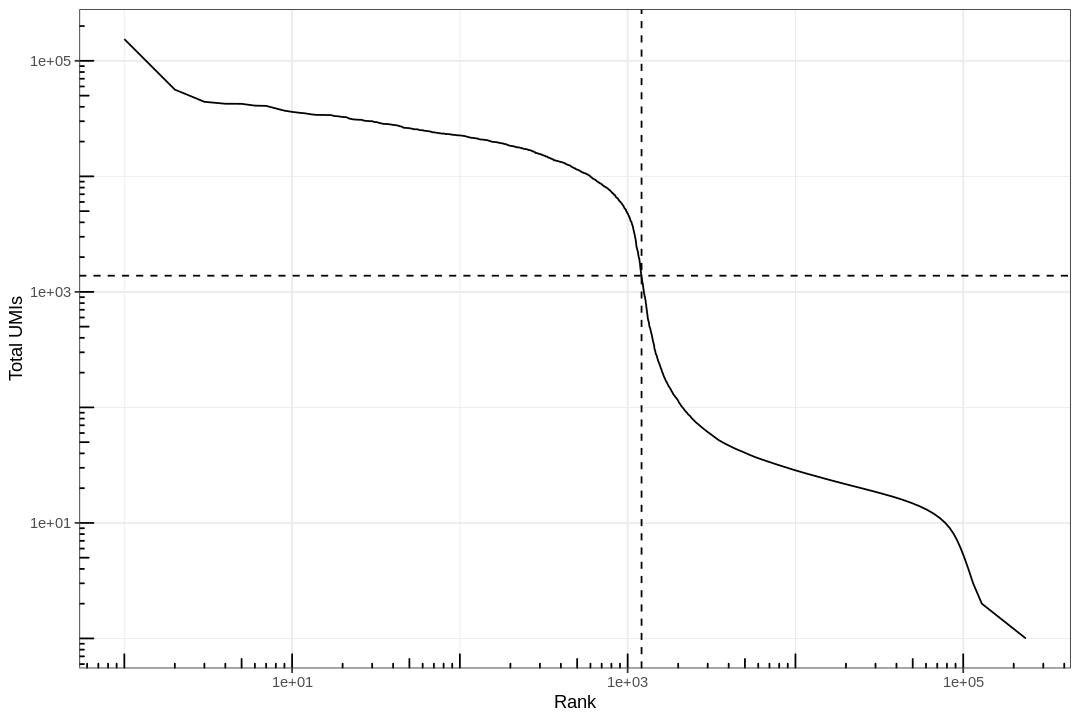

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [0]:
# Filter the matrix
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 20198  1210

In [0]:
rownames(res_mat) <- str_remove(rownames(res_mat), "\\.\\d+")

Now the number of cells is closer to expectation.

## Cell type inference
Monocle 2 only infers one trajectory for the entire dataset, so non-neuronal cells like endothelial cells and erythrocytes may be mistaken as highly differentiated cells from the neuronal lineage. So we will remove cell types not of the neural or glial lineages. Cell types are also helpful to orient the trajectory; neuronal progenitor cells must come before neurons. Here cell type inference is done programatically with [`SingleR`](https://github.com/dviraran/SingleR), which compares gene expression profiles of individual cells to bulk RNA-seq data of purified known cell types.

In [0]:
mouse.rnaseq <- MouseRNAseqData(ensembl = TRUE)
sce <- SingleCellExperiment(assays = list(counts = res_mat))
sce <- logNormCounts(sce)

Then `SingleR` will assign each cell a label based on Spearman correlation with known cell types from bulk RNA-seq. These are meanings of the acronyms:

* OPCs: Oligodendrocyte progenitor cells
* NPCs: Neural progenitor cells
* aNSCs: Active neural stem cells
* qNSCs: Quiescent neural stem cells

In [0]:
annots <- SingleR(sce, ref = mouse.rnaseq, labels = colData(mouse.rnaseq)$label.fine,
de.method = "wilcox", method = "single", BPPARAM = MulticoreParam(4))

In [0]:
annots

DataFrame with 1210 rows and 5 columns
                                                                        scores
                                                                      <matrix>
AAACGCTGTAATGTGA    0.0601901483760862:0.242986808015721:0.177660752587073:...
AAACGCTGTCCTGGGT      0.11153546550616:0.321858508786419:0.206383027494298:...
AAAGAACCAGGACATG    0.0585569289411892:0.225038532259566:0.177381655702582:...
AAAGGTACACACGGTC       0.137923692580242:0.3506611435018:0.281933499704427:...
AAAGGTATCACCATAG -0.00511350381259525:0.166880227412372:0.0975899954539976:...
...                                                                        ...
TTTGACTTCGTTCAGA     0.100933655338997:0.327948884202836:0.262011719832591:...
TTTGATCTCCATAGGT     0.0656536744266451:0.280702755051776:0.23375860874247:...
TTTGGAGAGGCTAACG    0.0681422805975054:0.234772340818692:0.176292333613646:...
TTTGGTTAGTAATCCC     0.125780004617712:0.315213344287222:0.258722018820061:...
TTTGTTGGTATGG

In [0]:
inds <- annots$pruned.labels %in% c("NPCs", "Neurons", "OPCs", "Oligodendrocytes", 
                                    "qNSCs", "aNSCs", "Astrocytes", "Ependymal")
# Only keep these cell types
cells_use <- row.names(annots)[inds]
sce <- sce[, cells_use]
sce$cell_type <- annots$pruned.labels[inds]

## QC

In [0]:
df <- perCellQCMetrics(sce)

In [0]:
colData(sce) <- cbind(colData(sce), df)

In [0]:
colData(sce)

DataFrame with 1146 rows and 8 columns
                   cell_type       sum  detected   percent_top_50
                 <character> <numeric> <integer>        <numeric>
AAACGCTGTAATGTGA       aNSCs      7072      3256 19.0328054298643
AAACGCTGTCCTGGGT       aNSCs      9458      4101 12.8991330090928
AAAGAACCAGGACATG       aNSCs      5338      2577 20.7006369426752
AAAGGTACACACGGTC       aNSCs     16892      5111 18.2098034572579
AAAGGTATCACCATAG       aNSCs      1397       882 24.9105225483178
...                      ...       ...       ...              ...
TTTGACTTCGTTCAGA       aNSCs     26203      6091 21.4021295271534
TTTGATCTCCATAGGT       aNSCs      8120      3625 16.7980295566502
TTTGGAGAGGCTAACG     Neurons      5483      2737 21.8675907349991
TTTGGTTAGTAATCCC     Neurons     24381      5927 20.2288667404946
TTTGTTGGTATGGAAT     Neurons      3718      2324 14.6046261430877
                  percent_top_100  percent_top_200  percent_top_500     total
                        <

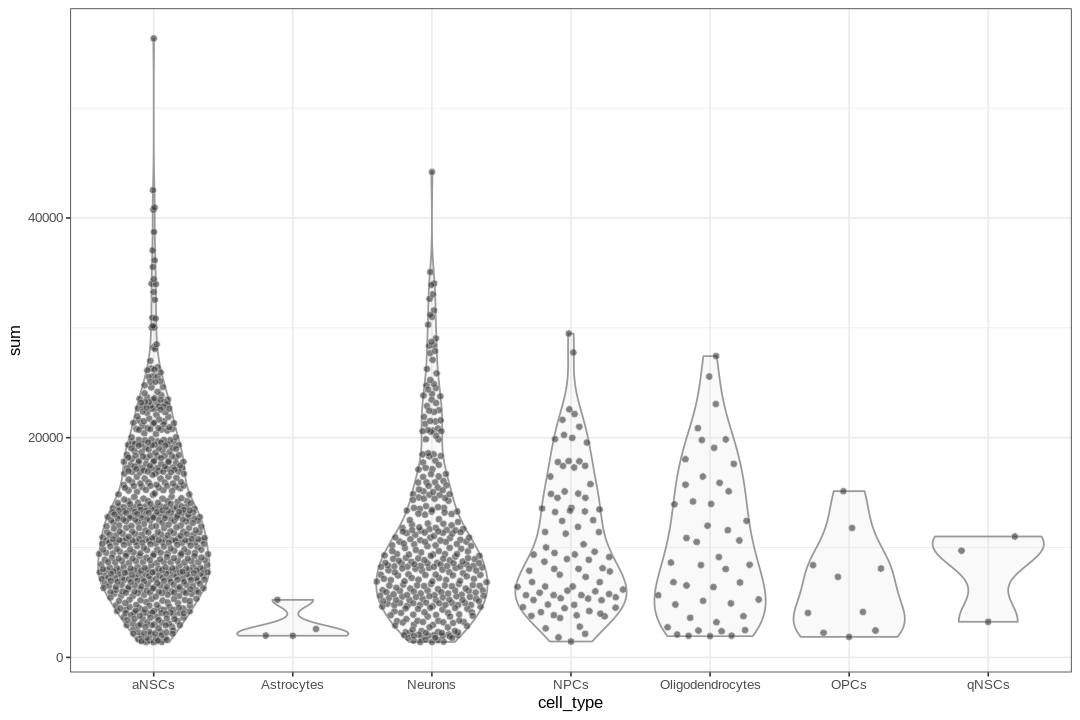

In [0]:
plotColData(sce, x = "cell_type", y = "sum")

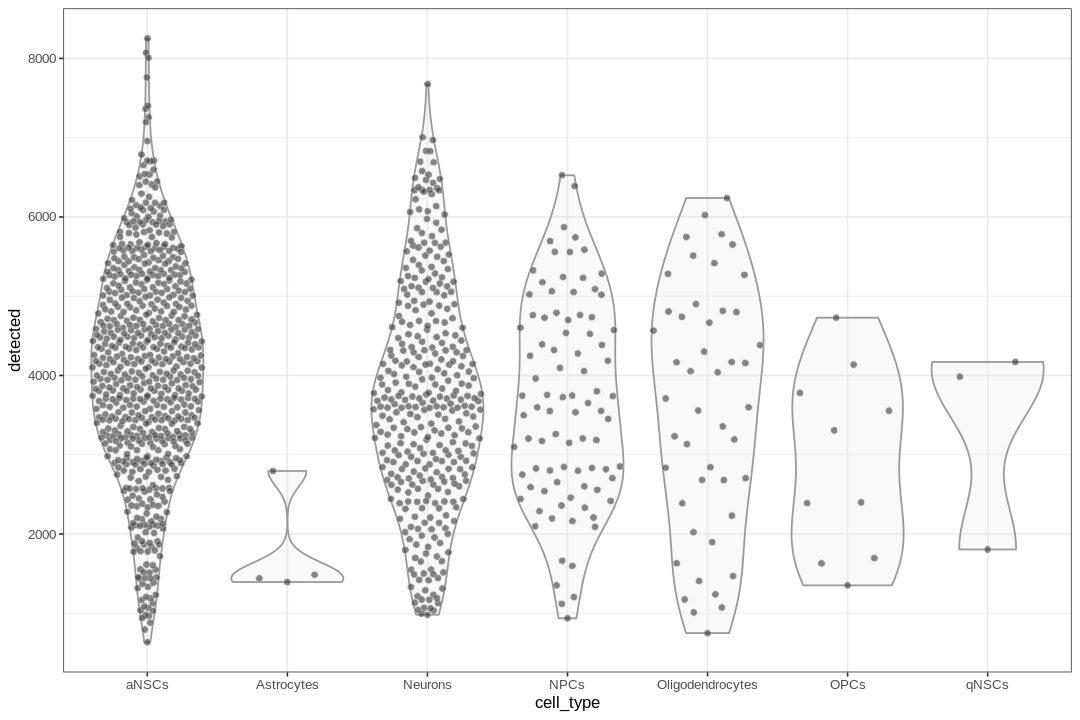

In [0]:
plotColData(sce, x = "cell_type", y = "detected")

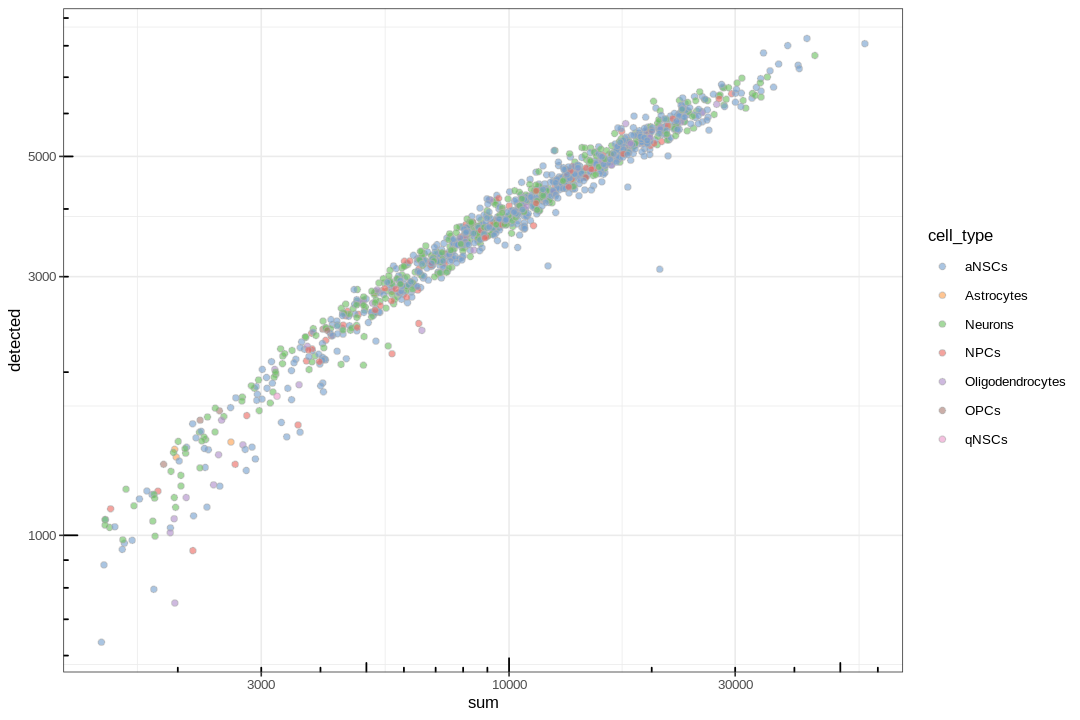

In [0]:
plotColData(sce, x = "sum", y = "detected", colour_by = "cell_type") +
  scale_x_log10() +
  scale_y_log10() +
  annotation_logticks()

# Monocle 2

In [0]:
# Construct CellDataSet object
pd <- data.frame(cell_id = cells_use, 
                 cell_type = annots$pruned.labels[inds],
                 row.names = cells_use)
pd <- new("AnnotatedDataFrame", data = pd)
fd <- data.frame(gene_id = rownames(sce), 
                 gene_short_name = tr2g$gene_name[match(rownames(sce), tr2g$gene)],
                 row.names = row.names(sce))
fd <- new("AnnotatedDataFrame", data = fd)
cds <- newCellDataSet(counts(sce), phenoData = pd, featureData = fd)

Size factor and dispersion will be used to normalize data and select genes for clustering.

In [0]:
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

Removing 16 outliers



Genes that aren't highly expressed enough will not be used for clustering, since they may not give meaningful signal and would only add noise.

In [0]:
disp_table <- dispersionTable(cds)
clustering_genes <- subset(disp_table, mean_expression >= 0.1)
cds <- setOrderingFilter(cds, clustering_genes$gene_id)

In [0]:
cds <- reduceDimension(cds, num_dim = 40, reduction_method = 'tSNE')
cds <- clusterCells(cds, method = "louvain")

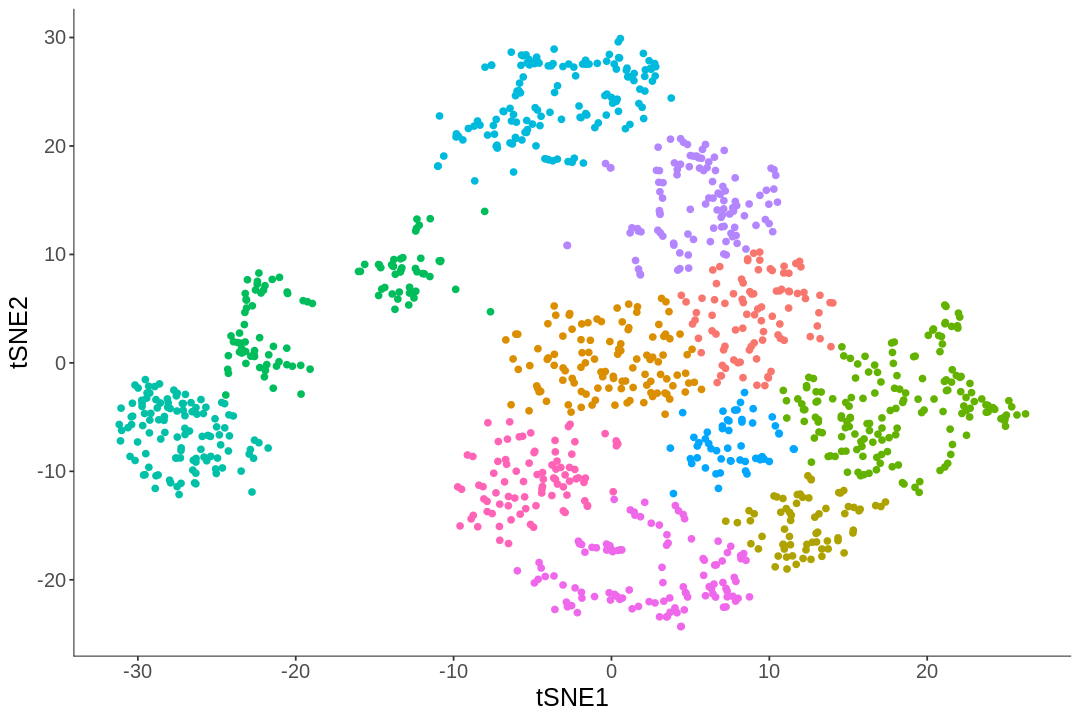

In [0]:
plot_cell_clusters(cds) +
  theme(legend.position = "none") +
  labs(x = "tSNE1", y = "tSNE2")

See where the annotated cell types are

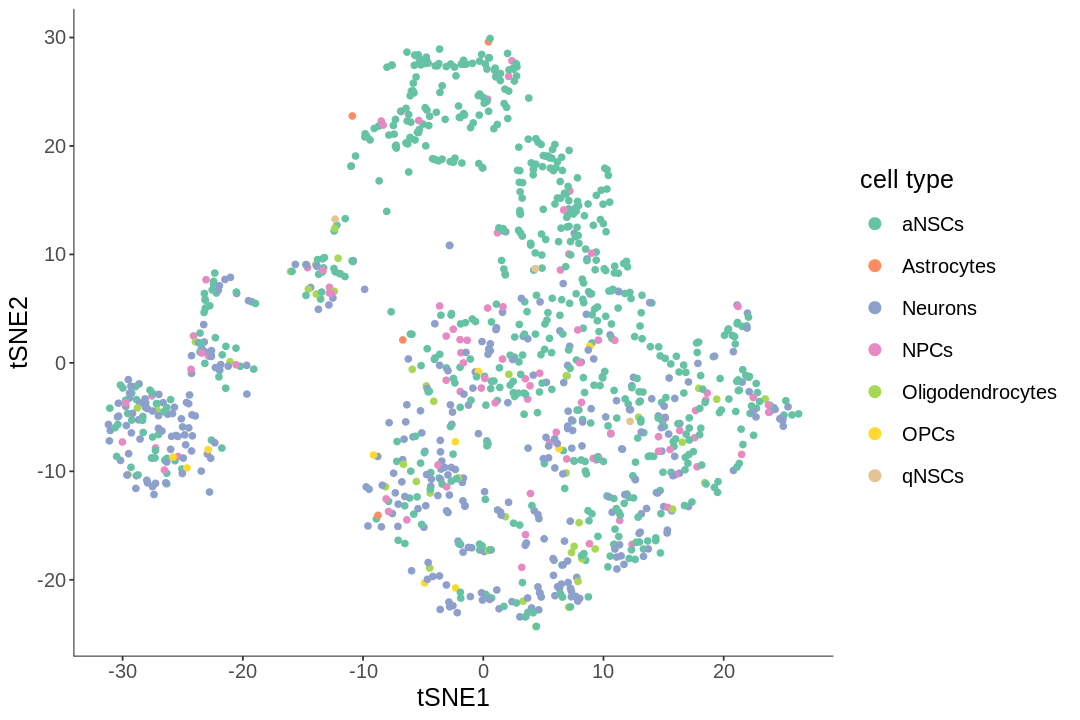

In [0]:
plot_cell_clusters(cds, color_by = "cell_type") +
  scale_color_brewer(name = "cell type", type = "qual", palette = "Set2") +
  labs(x = "tSNE1", y = "tSNE2") +
  theme(legend.position = "right") +
  guides(color = guide_legend(override.aes = list(size = 3)))

Genes likely to be informative of ordering of cells along the pseudotime trajectory will be selected for pseudotime inference.

In [0]:
diff_genes <- differentialGeneTest(cds, fullModelFormulaStr = "~ Cluster + cell_type",
                                   cores = 4)
# Use top 3000 differentially expressed genes
ordering_genes <- row.names(subset(diff_genes, qval < 1e-3))[order(diff_genes$qval)][1:3000]
cds <- setOrderingFilter(cds, ordering_genes)

Here Monocle 2 will first project the data to 2 dimensions with `DDRTree`, and then do trajectory inference (`orderCells`).

In [0]:
cds <- reduceDimension(cds, max_components = 2, method = 'DDRTree')
cds <- orderCells(cds)

See what the trajectory looks like. This projection is `DDRTree`.

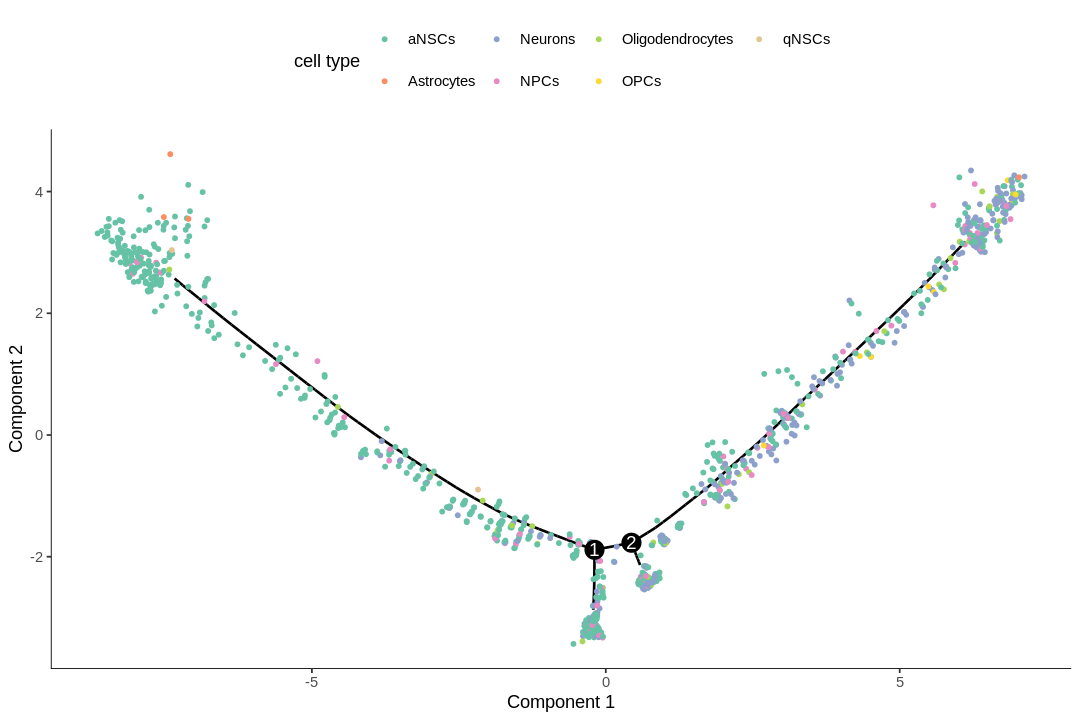

In [0]:
plot_cell_trajectory(cds, color_by = "cell_type", cell_size = 1) +
  scale_color_brewer(name = "cell type", type = "qual", palette = "Set2")

In the [kallisto | bustools paper](https://www.biorxiv.org/content/10.1101/673285v1), I used `slingshot` for pseudotime analysis (Supplementary Figure 6.5) of this dataset, and found two neuronal end points. The result from Monocle 2 here also shows two main branches. Also, as expected, the stem cells are at the very beginning of the trajectory.

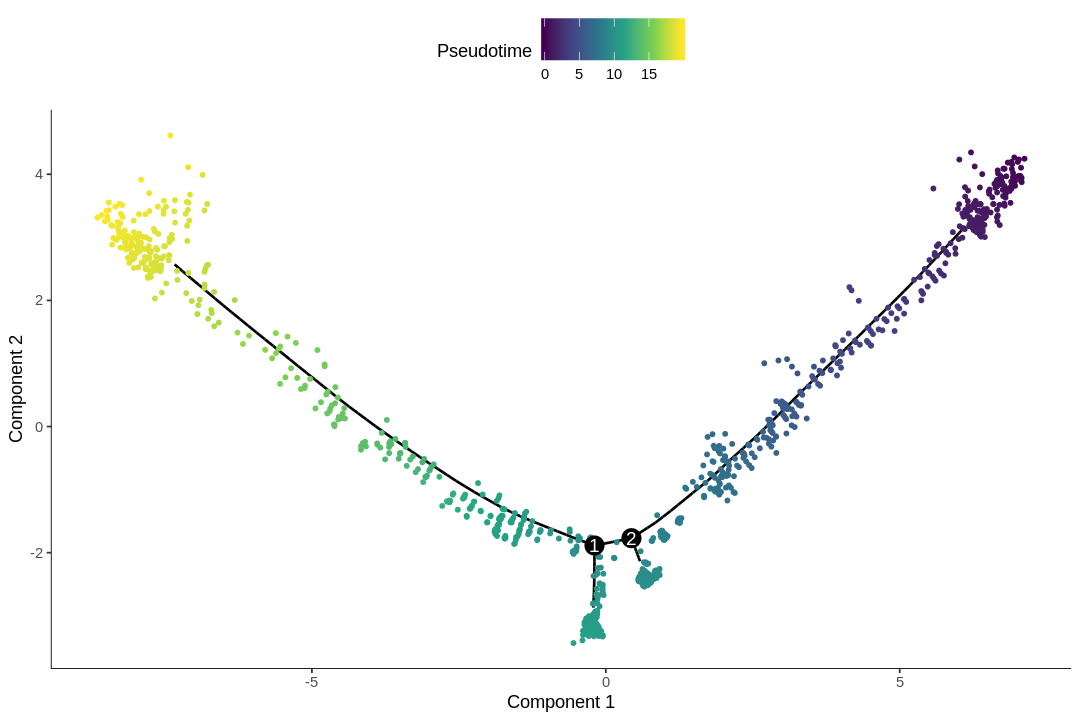

In [0]:
plot_cell_trajectory(cds, color_by = "Pseudotime", cell_size = 1) +
  scale_color_viridis_c()

The pseudotime values are inverted.

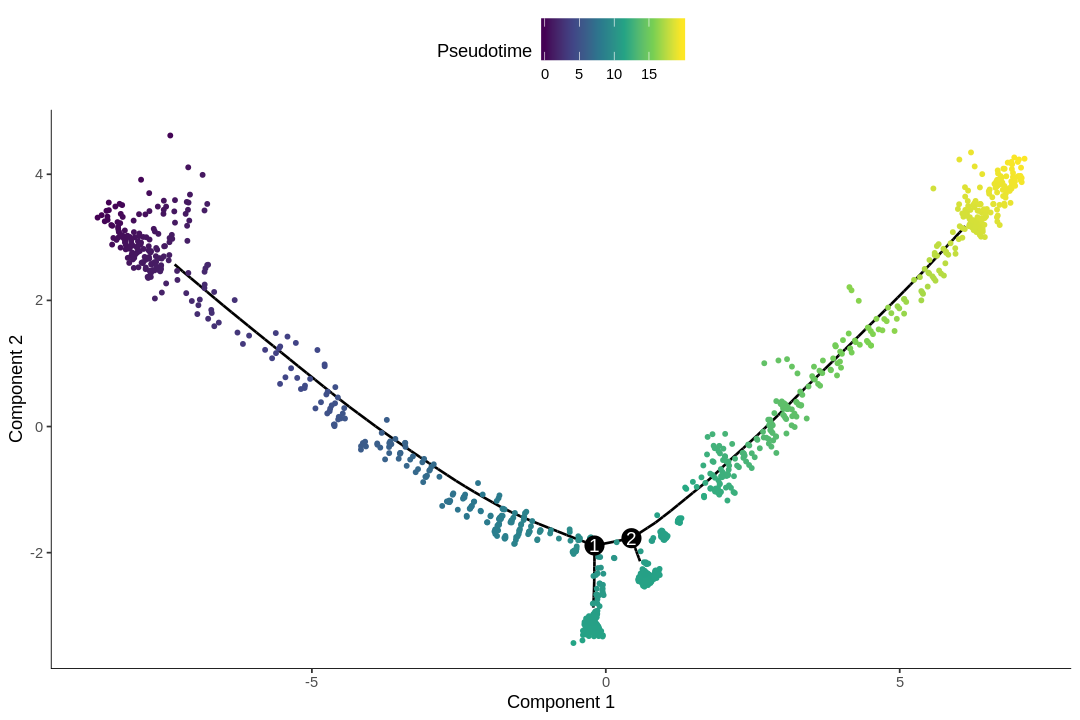

In [0]:
cds <- orderCells(cds, reverse = TRUE)
plot_cell_trajectory(cds, color_by = "Pseudotime", cell_size = 1) +
  scale_color_viridis_c()

Monocle 2 can also be used to find genes differentially expressed along the pseudotime trajectory and clusters of such genes. See [David Tang's excellent Monocle 2 tutorial](https://davetang.org/muse/2017/10/01/getting-started-monocle/) for how to use these functionalities.